# Imbalanced Testing

In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    get_info_experiment
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data


In [ ]:
# Re-import necessary libraries after kernel reset
import numpy as np
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

def create_relevance_function(y):
    """
    Create a PCHIP-based relevance function φ(y) using adjusted boxplot bounds.
    """
    lower, median, upper = compute_adjusted_boxplot_bounds(y)
    
    # Extend with actual min/max to smooth edges
    # x = np.array([min(y), lower, median, upper, max(y)])
    x = np.array([lower, median, upper, max(y)])
    # if x[1] < x[0]:
    #     x[1] = (x[0]+ x[2])/2
    relevance = np.array([0, 0, 1.0, 1.0])

    # Ensure strictly increasing x by removing duplicate values
    x_unique, idx = np.unique(x, return_index=True)
    relevance_unique = relevance[idx]
    print(x_unique)
    print(relevance_unique)
    pchip = PchipInterpolator(x_unique, relevance_unique, extrapolate=True)
    return pchip

def compute_sera(y_true, y_pred, relevance_fn, step=0.01):
    """
    Compute SERA metric given true values, predictions, and a relevance function φ(y).
    """
    t_values = np.arange(0, 1 + step, step)
    ser_t = []

    for t in t_values:
        indices = [i for i, y in enumerate(y_true) if relevance_fn(y) >= t]
        if len(indices) == 0:
            ser_t.append(0.0)
            continue
        squared_errors = [(y_pred[i] - y_true[i]) ** 2 for i in indices]
        ser_t.append(np.sum(squared_errors))

    sera_score = np.trapz(ser_t, t_values)
    return sera_score, t_values, ser_t

In [5]:
# TensorFlow-compatible SERA metric wrapper
def compute_sera_tensor(y_true, y_pred, relevance_fn, step=0.01):
    """
    TensorFlow-compatible version of SERA for use as a metric in Keras.
    Assumes y_true and y_pred are 1D tensors.
    `relevance_fn` must be a NumPy function; we'll wrap it using tf.numpy_function.
    """
    def sera_np(y_true_np, y_pred_np):
        t_values = np.arange(0, 1 + step, step)
        ser_t = []
        rel_true = relevance_fn(y_true_np)

        for t in t_values:
            indices = np.where(rel_true >= t)[0]
            if len(indices) == 0:
                ser_t.append(0.0)
                continue
            errors = (y_pred_np[indices] - y_true_np[indices]) ** 2
            ser_t.append(np.mean(errors))

        sera_score = np.trapz(ser_t, t_values)
        return np.float32(sera_score)

    return tf.numpy_function(sera_np, [y_true, y_pred], tf.float32)

In [6]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")


In [7]:
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])

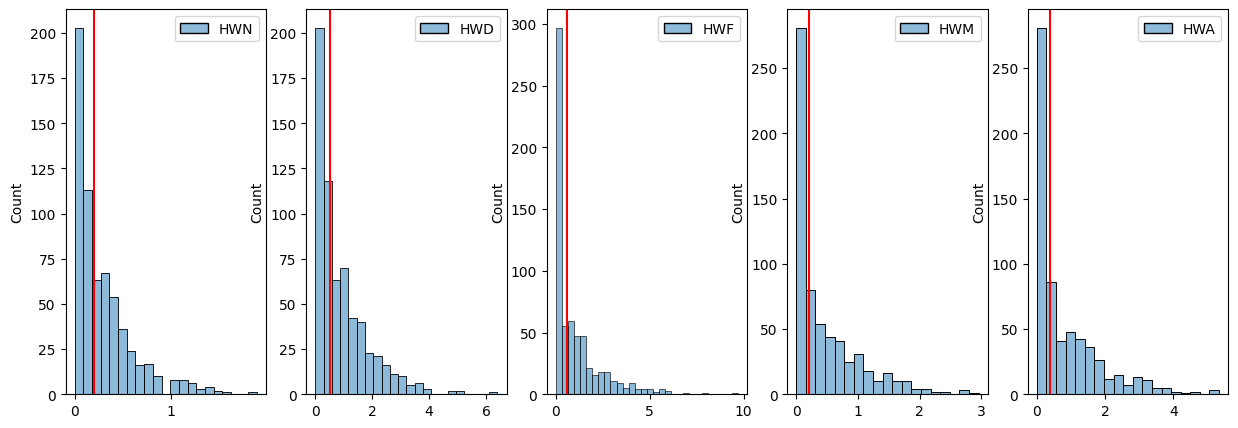

In [7]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])
    axs[i].axvline(np.median(hws[[index]]), color='red')

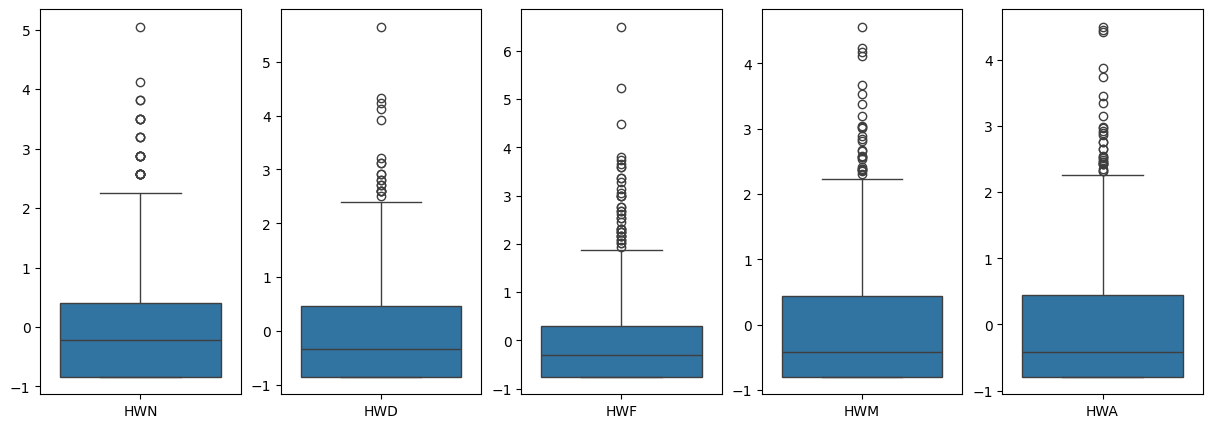

In [9]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.boxplot(hws[[index]], ax=axs[i])

In [10]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])

In [11]:
compute_adjusted_boxplot_bounds(hws_index)

(-1.1692892810242344, -0.30647585455315646, 4.561547586528888)

In [ ]:
relevance = create_relevance_function(hws_index)

[-1.16928928 -0.30647585  4.56154759  6.49996949]
[0. 0. 1. 1.]


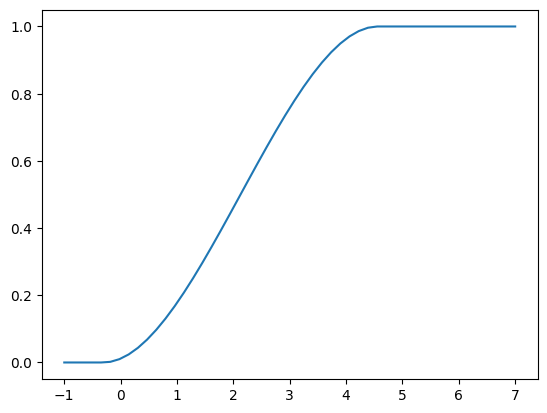

In [13]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))

Epoch 1/200
6/6 [==============================] - 1s 53ms/step - loss: 0.8086 - val_loss: 0.9027
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 0.7885 - val_loss: 0.8848
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 0.7617 - val_loss: 0.8707
Epoch 4/200
6/6 [==============================] - 0s 7ms/step - loss: 0.7256 - val_loss: 0.8565
Epoch 5/200
6/6 [==============================] - 0s 7ms/step - loss: 0.7222 - val_loss: 0.8452
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6879 - val_loss: 0.8359
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6900 - val_loss: 0.8251
Epoch 8/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6606 - val_loss: 0.8156
Epoch 9/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6386 - val_loss: 0.8073
Epoch 10/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6319 - val_loss: 0.7986
Epoch 11/200
6/6 [==========

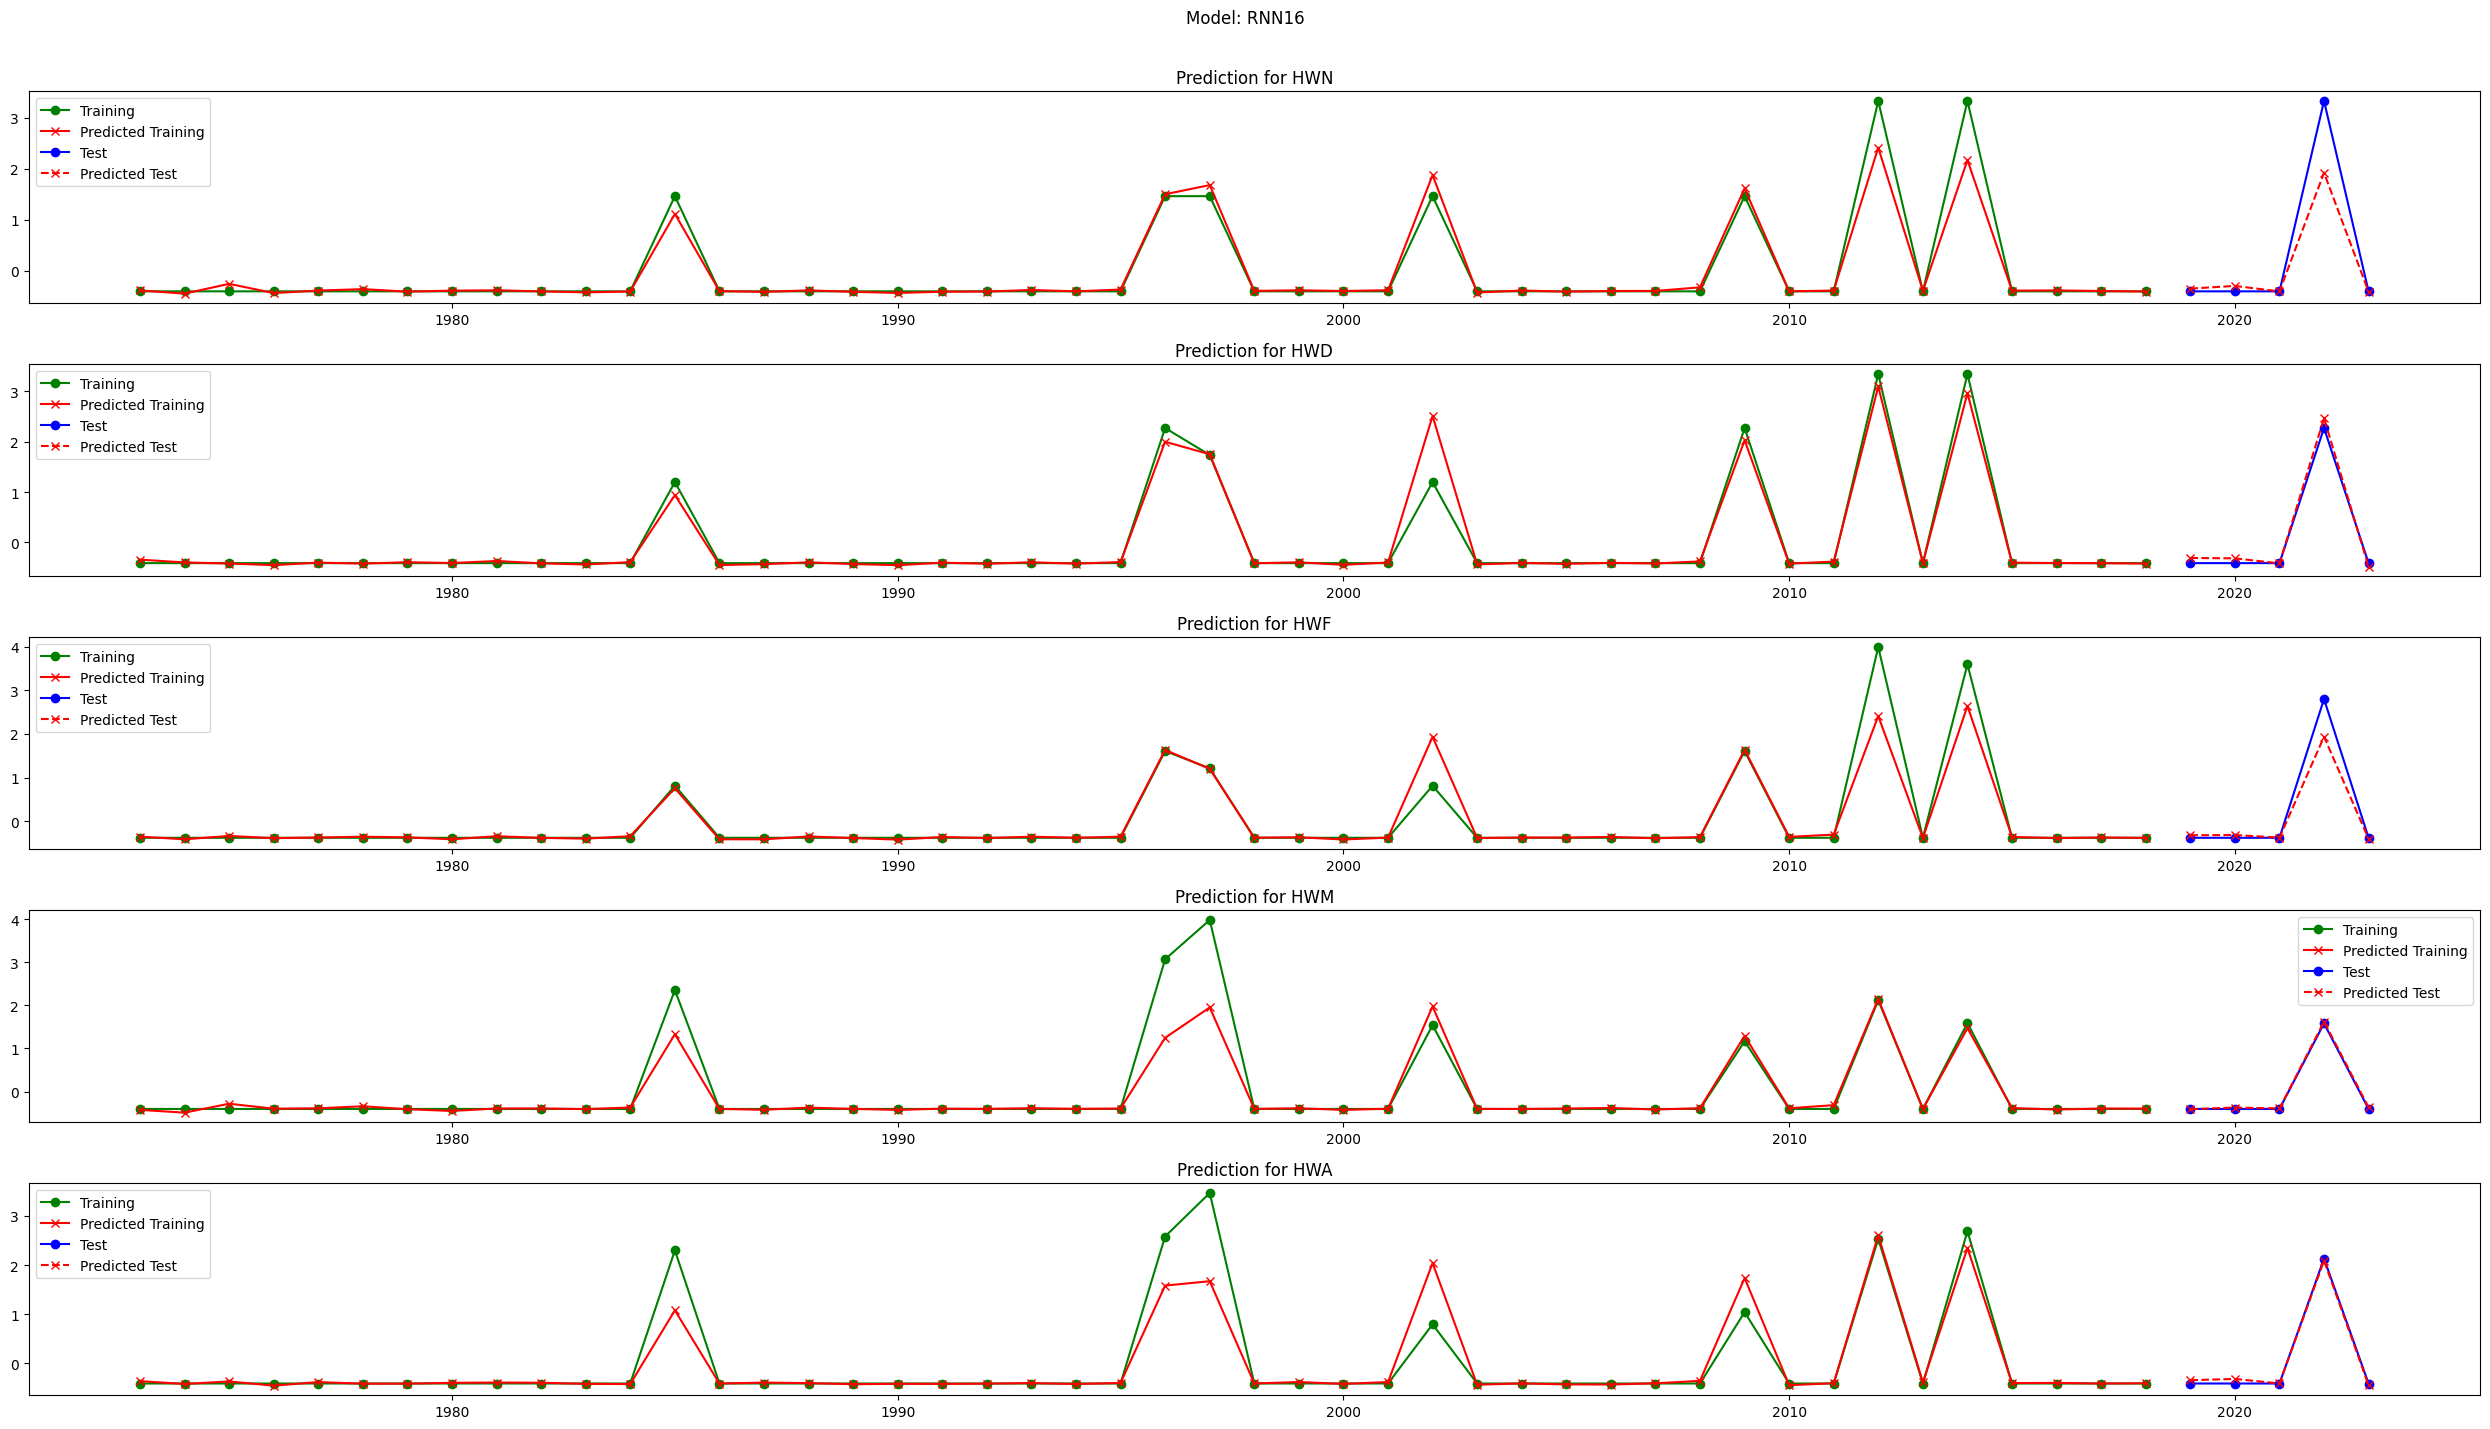

In [14]:
id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [16]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [17]:
print("Prediction SERA", sera_score)

Prediction SERA 0.528128252281967


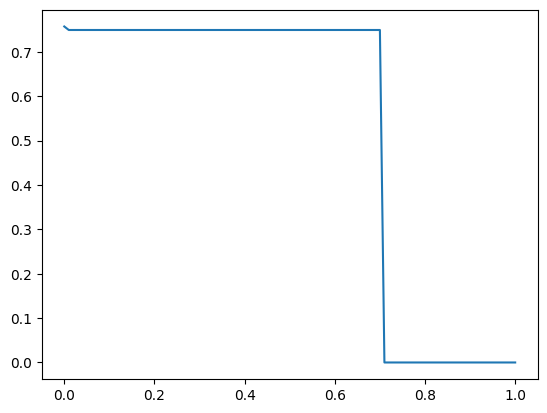

In [18]:
plt.plot(t_s, ser_t)

In [19]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 3.411442820739009


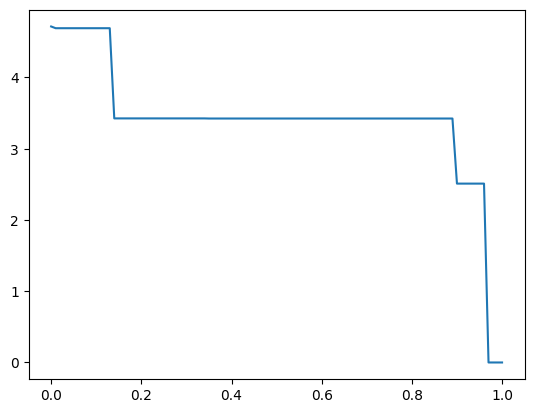

In [20]:
plt.plot(t_s, ser_t)

Epoch 1/200
6/6 [==============================] - 1s 32ms/step - loss: 1.0186 - val_loss: 1.0125
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 1.0159 - val_loss: 0.9981
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9993 - val_loss: 0.9826
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.9326 - val_loss: 0.9707
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.9358 - val_loss: 0.9598
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9255 - val_loss: 0.9482
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8723 - val_loss: 0.9360
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8925 - val_loss: 0.9238
Epoch 9/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8787 - val_loss: 0.9127
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8349 - val_loss: 0.9015
Epoch 11/200
6/6 [==========

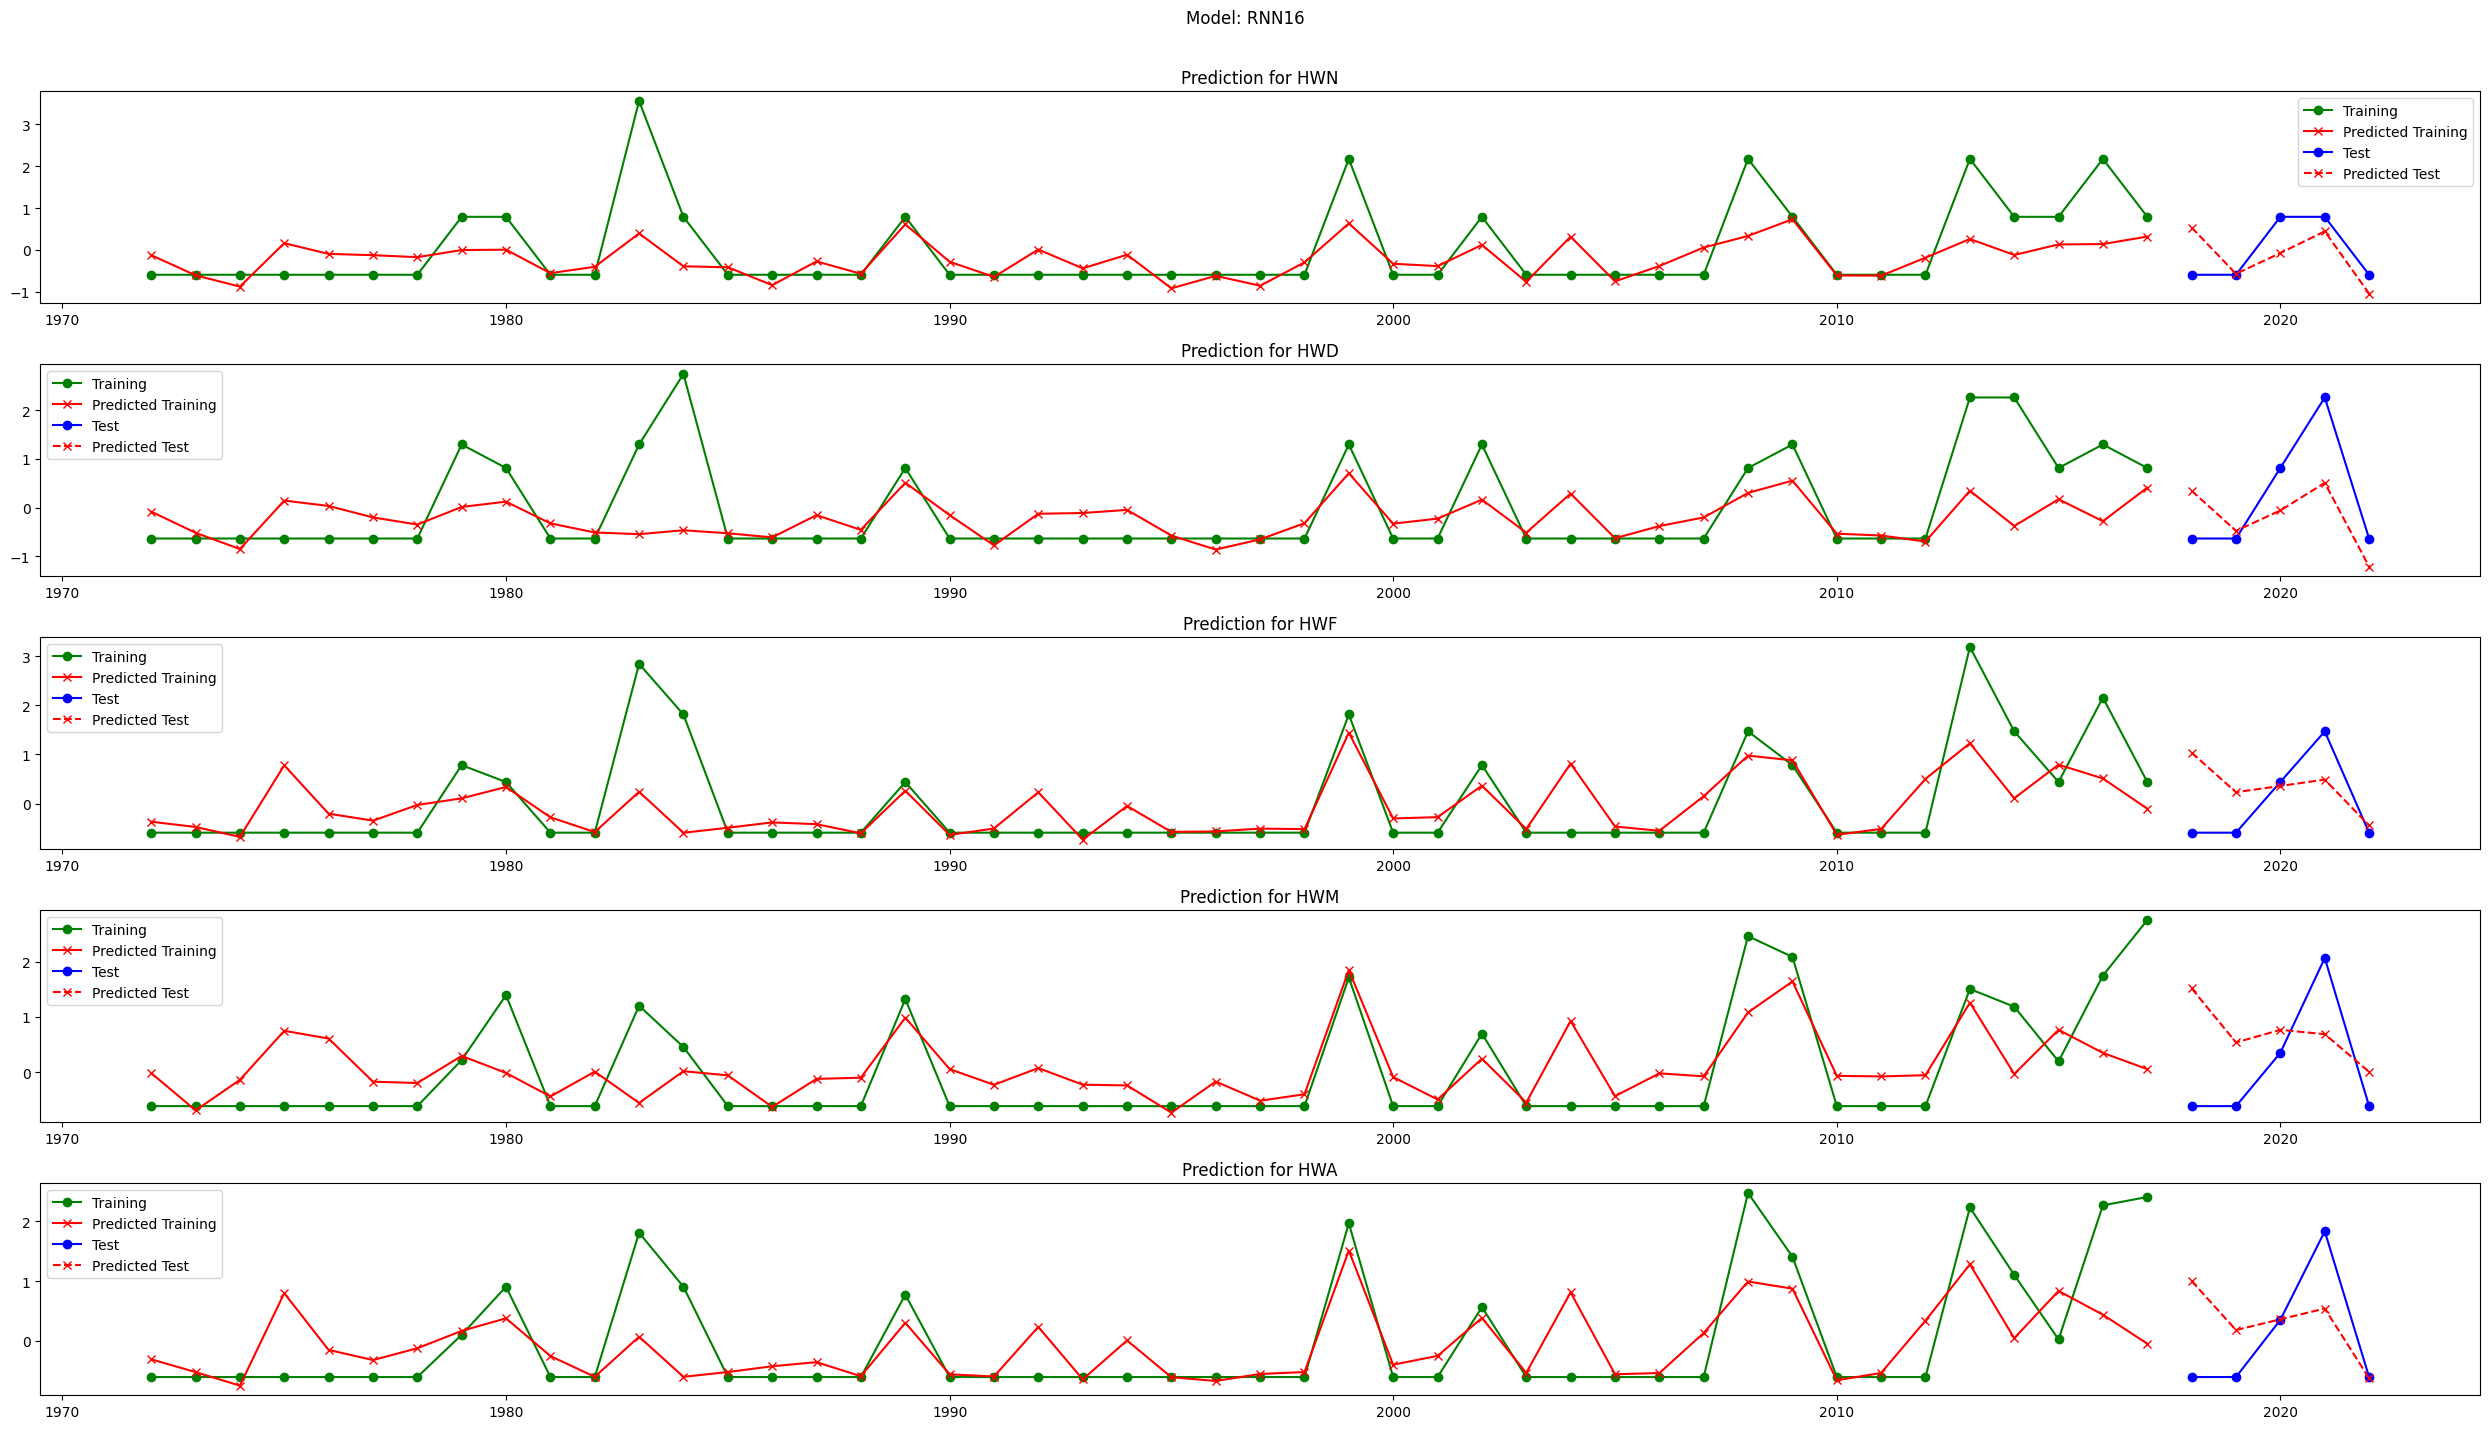

In [21]:
id = "231a6330"
season = 1
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [22]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [23]:
print("Prediction SERA", sera_score)

Prediction SERA 0.31072956744531044


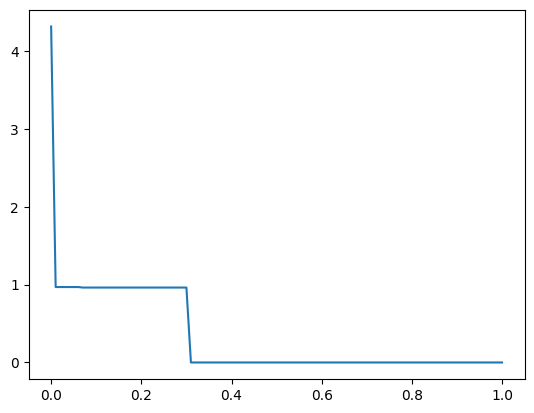

In [24]:
plt.plot(t_s, ser_t)

In [25]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 12.4865107791244


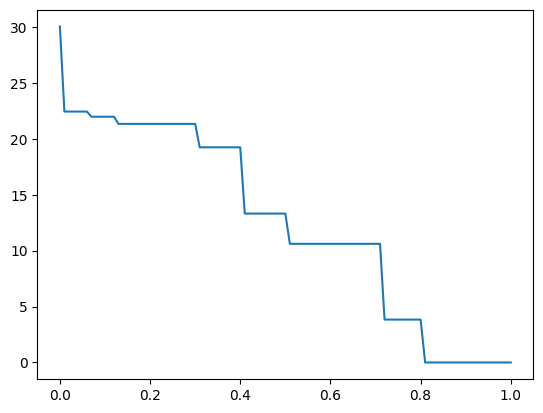

In [26]:
plt.plot(t_s, ser_t)

Epoch 1/200
6/6 [==============================] - 1s 36ms/step - loss: 0.5493 - val_loss: 0.3678
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4911 - val_loss: 0.3441
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4872 - val_loss: 0.3219
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4625 - val_loss: 0.2994
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4382 - val_loss: 0.2789
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4318 - val_loss: 0.2671
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4317 - val_loss: 0.2551
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4114 - val_loss: 0.2440
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3876 - val_loss: 0.2341
Epoch 10/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3636 - val_loss: 0.2262
Epoch 11/200
6/6 [==========

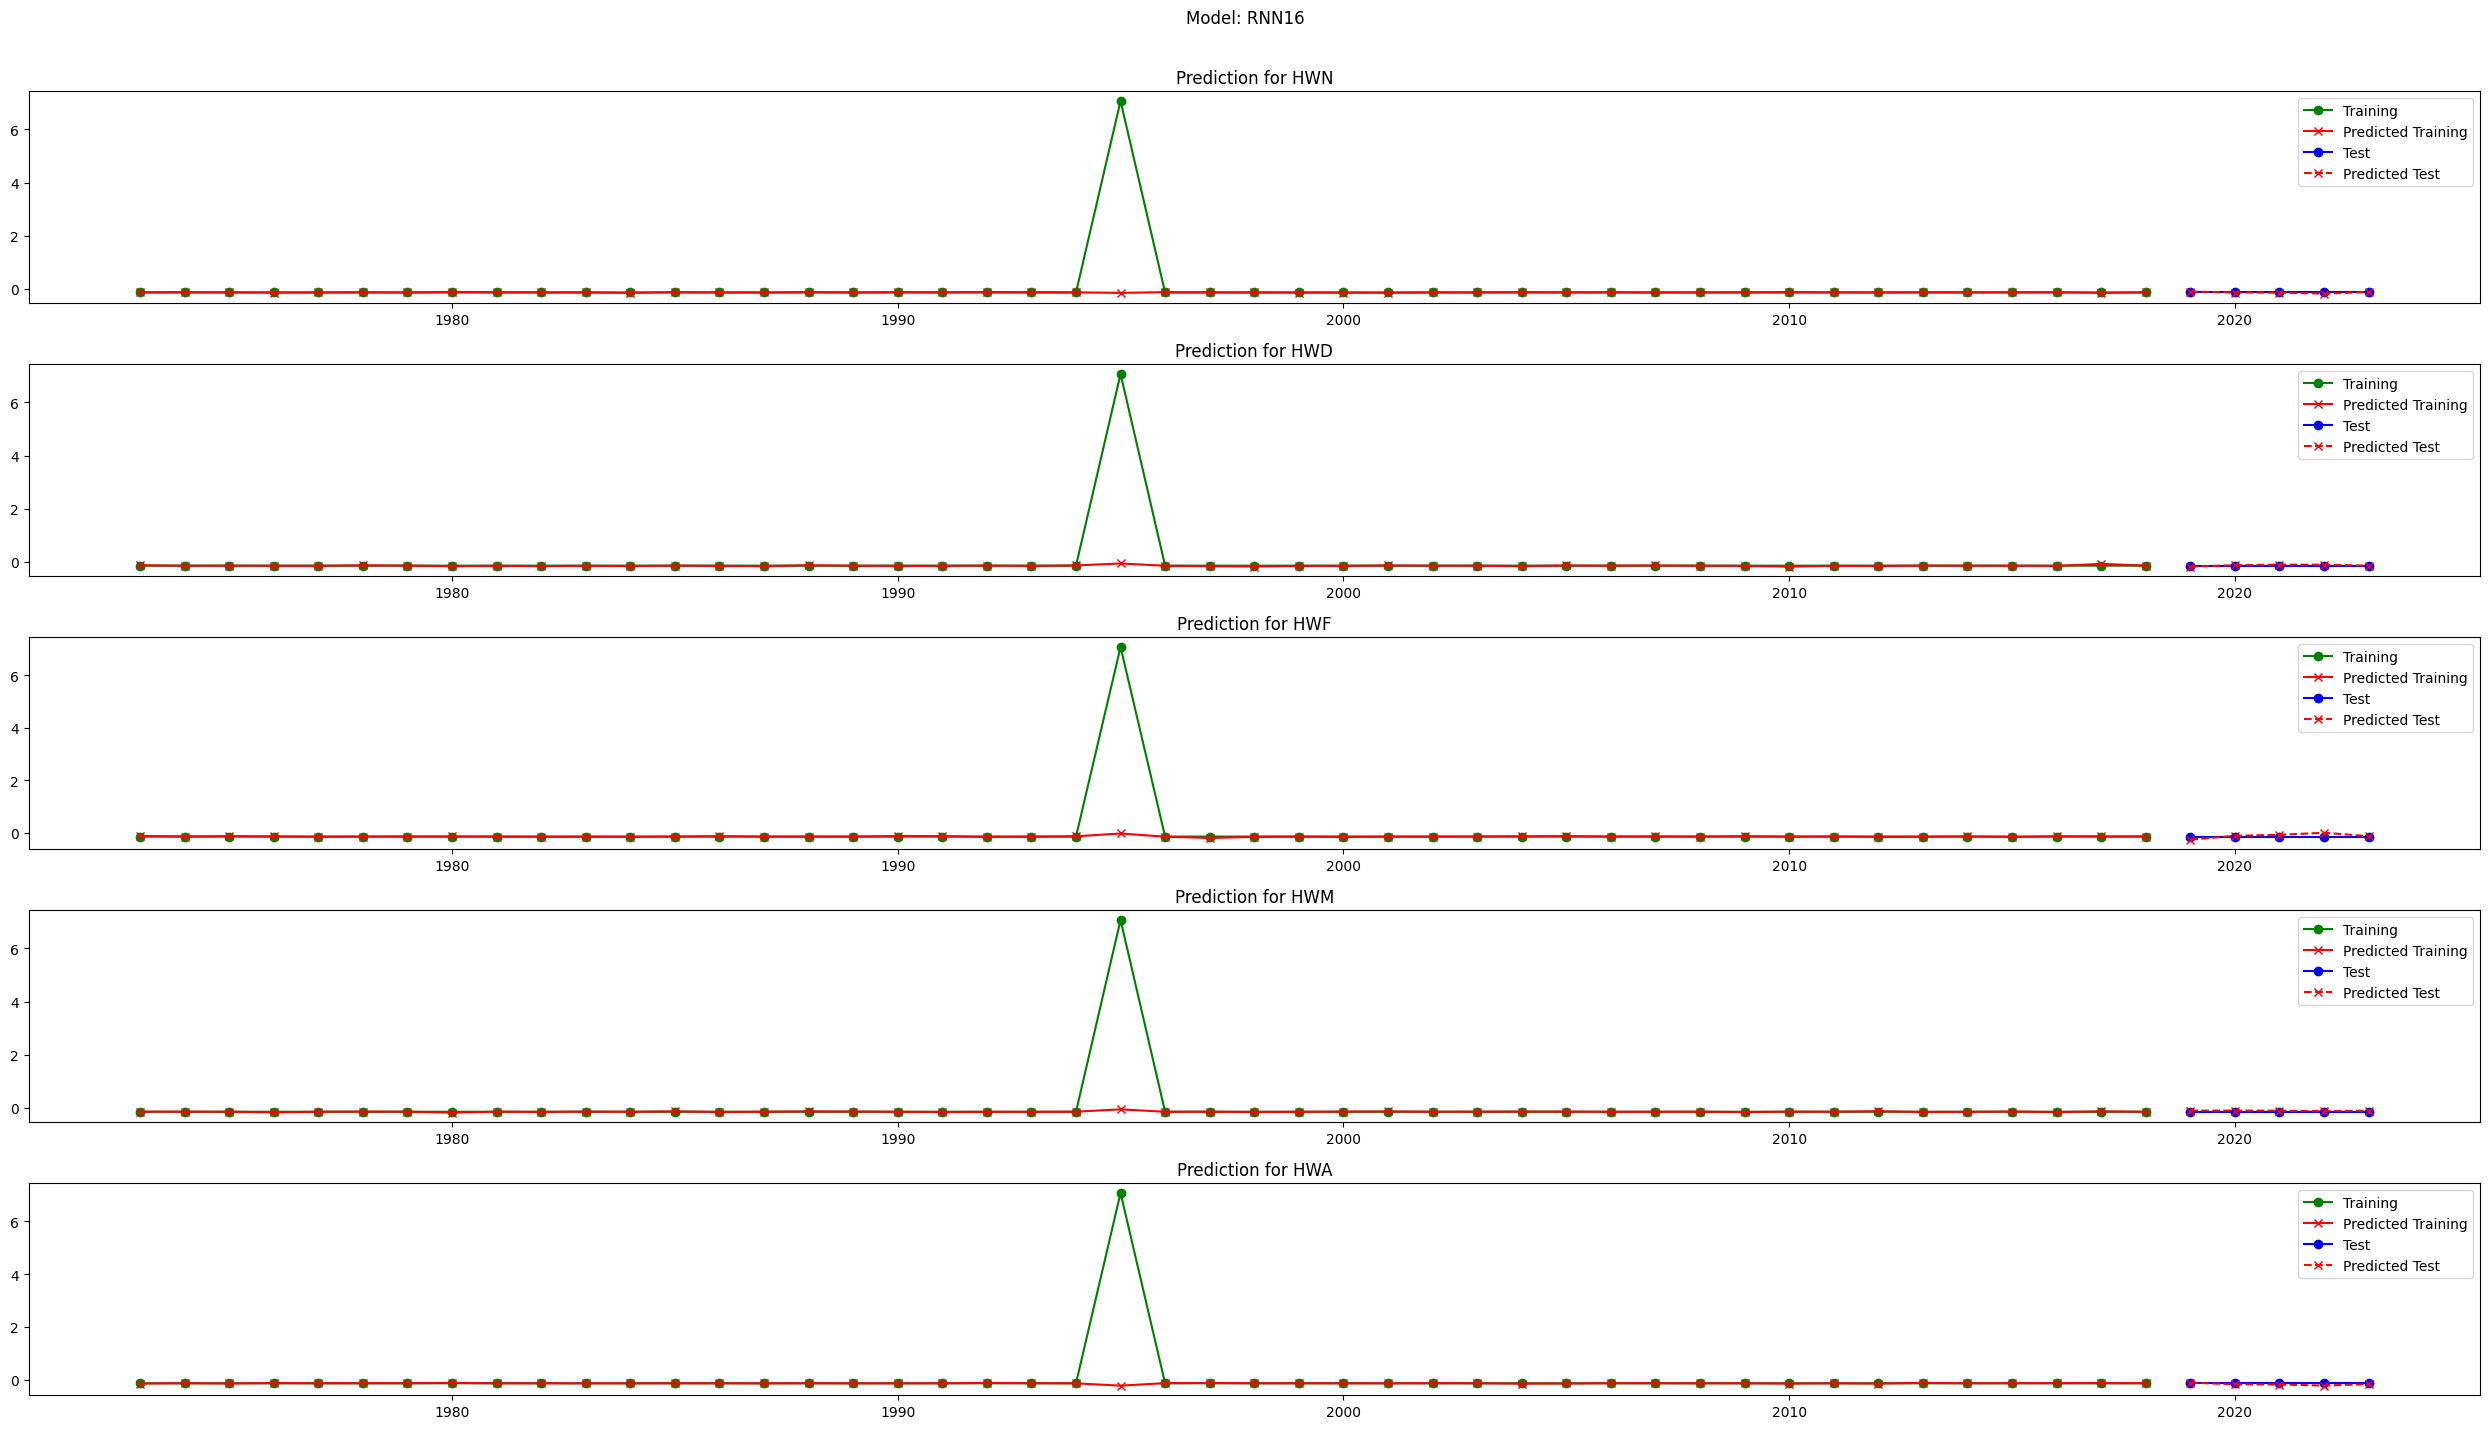

In [27]:
id = "e0ec7330"
season = 6
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])
pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [28]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [29]:
print("Prediction SERA", sera_score)

Prediction SERA 0.0002024054622327585


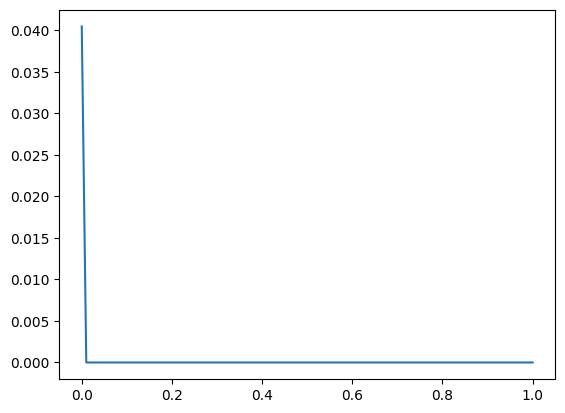

In [30]:
plt.plot(t_s, ser_t)

In [31]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 50.34314271746695


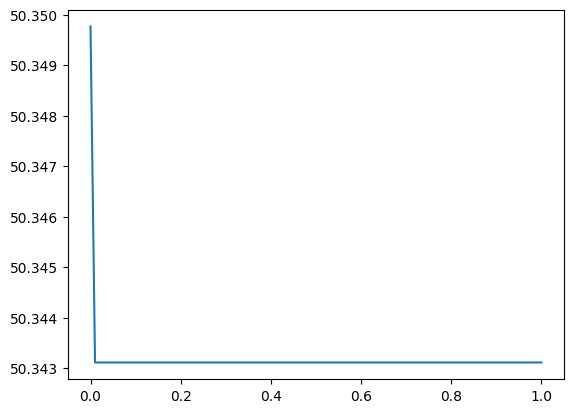

In [32]:
plt.plot(t_s, ser_t)

## Model eval with SERA metric

In [14]:
def make_sera_metric(relevance_fn, step=0.01):
    def sera_metric(y_true, y_pred):
        return compute_sera_tensor(y_true, y_pred, relevance_fn, step)
    return sera_metric


In [ ]:
id = "231a6330"
season = 1
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.train_predict(5)
pred.compile_keras_model(metrics=[make_sera_metric(relevance)])
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 1s 37ms/step - loss: 0.9868 - val_loss: 0.8656
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9616 - val_loss: 0.8559
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9429 - val_loss: 0.8462
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9119 - val_loss: 0.8373
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.9056 - val_loss: 0.8283
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.9004 - val_loss: 0.8193
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8864 - val_loss: 0.8103
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8414 - val_loss: 0.8015
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8590 - val_loss: 0.7928
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8249 - val_loss: 0.7848
Epoch 11/200
6/6 [==========

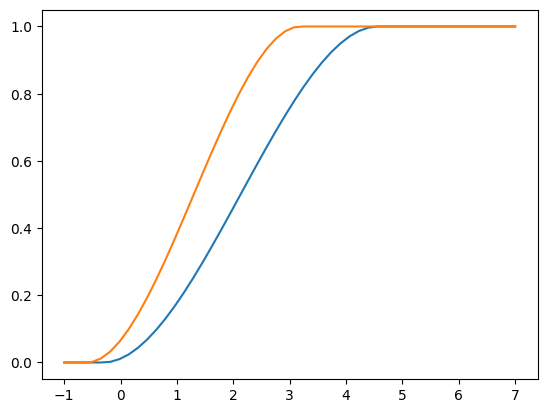

In [ ]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, pred.training_relevance_fs["HWF"](x))

Relevance points [-0.63642728 -0.59832112  3.56273032 42.57717223]
Relevance points [-0.67377248 -0.63399685  2.74416547 44.43306101]
Relevance points [-0.62107111 -0.59275725  3.18607024 31.48774169]
Relevance points [-0.63817174 -0.61045041  2.75237424 30.79869642]
Relevance points [-0.6315283  -0.60262397  2.46959152 32.14690315]
Epoch 1/200
6/6 [==============================] - 1s 32ms/step - loss: 0.8212 - val_loss: 0.9021
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.8276 - val_loss: 0.8922
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7963 - val_loss: 0.8800
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7977 - val_loss: 0.8708
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7983 - val_loss: 0.8637
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7566 - val_loss: 0.8607
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7396 - va

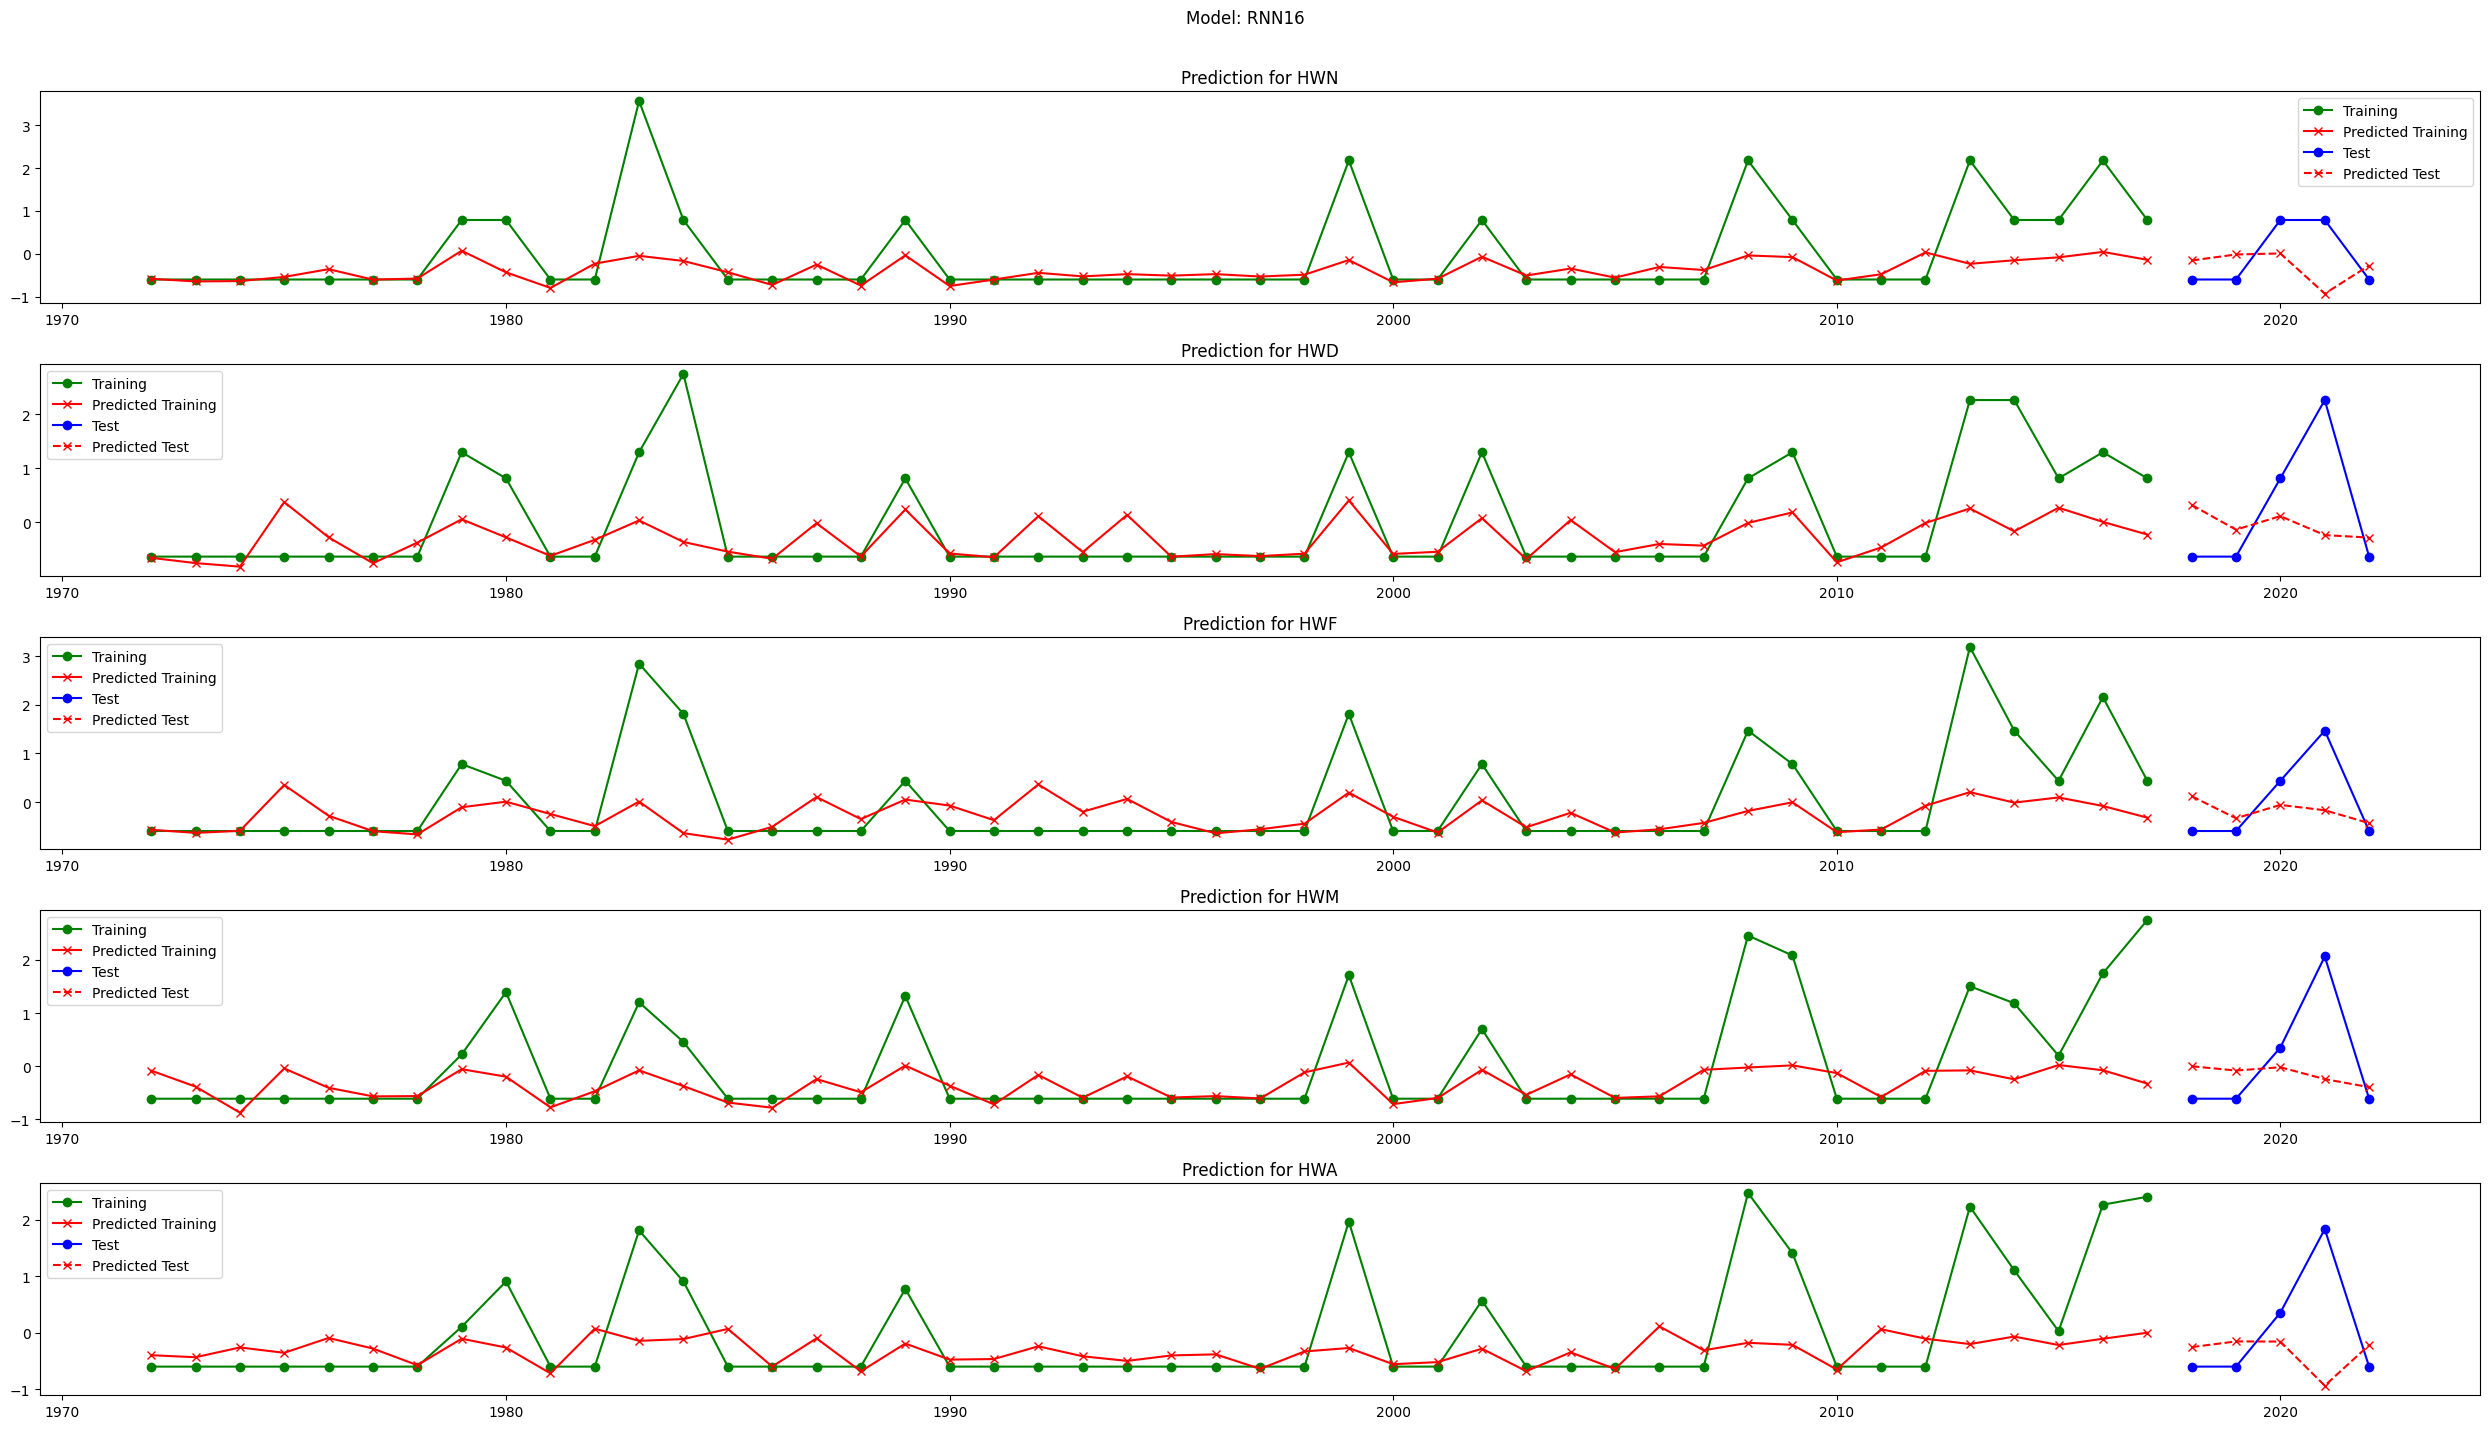

In [13]:
id = "231a6330"
season = 1
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Relevance points [-0.14142136  7.07106781]
Relevance points [-0.14142136  7.07106781]
Relevance points [-0.14142136  7.07106781]
Relevance points [-0.14142136  7.07106781]
Relevance points [-0.14142136  7.07106781]
Epoch 1/200
6/6 [==============================] - 1s 42ms/step - loss: 0.8193 - sera_metric: 6.6812 - val_loss: 0.8920 - val_sera_metric: 0.0044
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 0.7585 - sera_metric: 6.8520 - val_loss: 0.8322 - val_sera_metric: 0.0039
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7068 - sera_metric: 6.8978 - val_loss: 0.7778 - val_sera_metric: 0.0034
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 0.6591 - sera_metric: 7.0062 - val_loss: 0.7240 - val_sera_metric: 0.0030
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6345 - sera_metric: 8.3043 - val_loss: 0.6716 - val_sera_metric: 0.0027
Epoch 6/200
6/6 [==============================] - 0s 10m

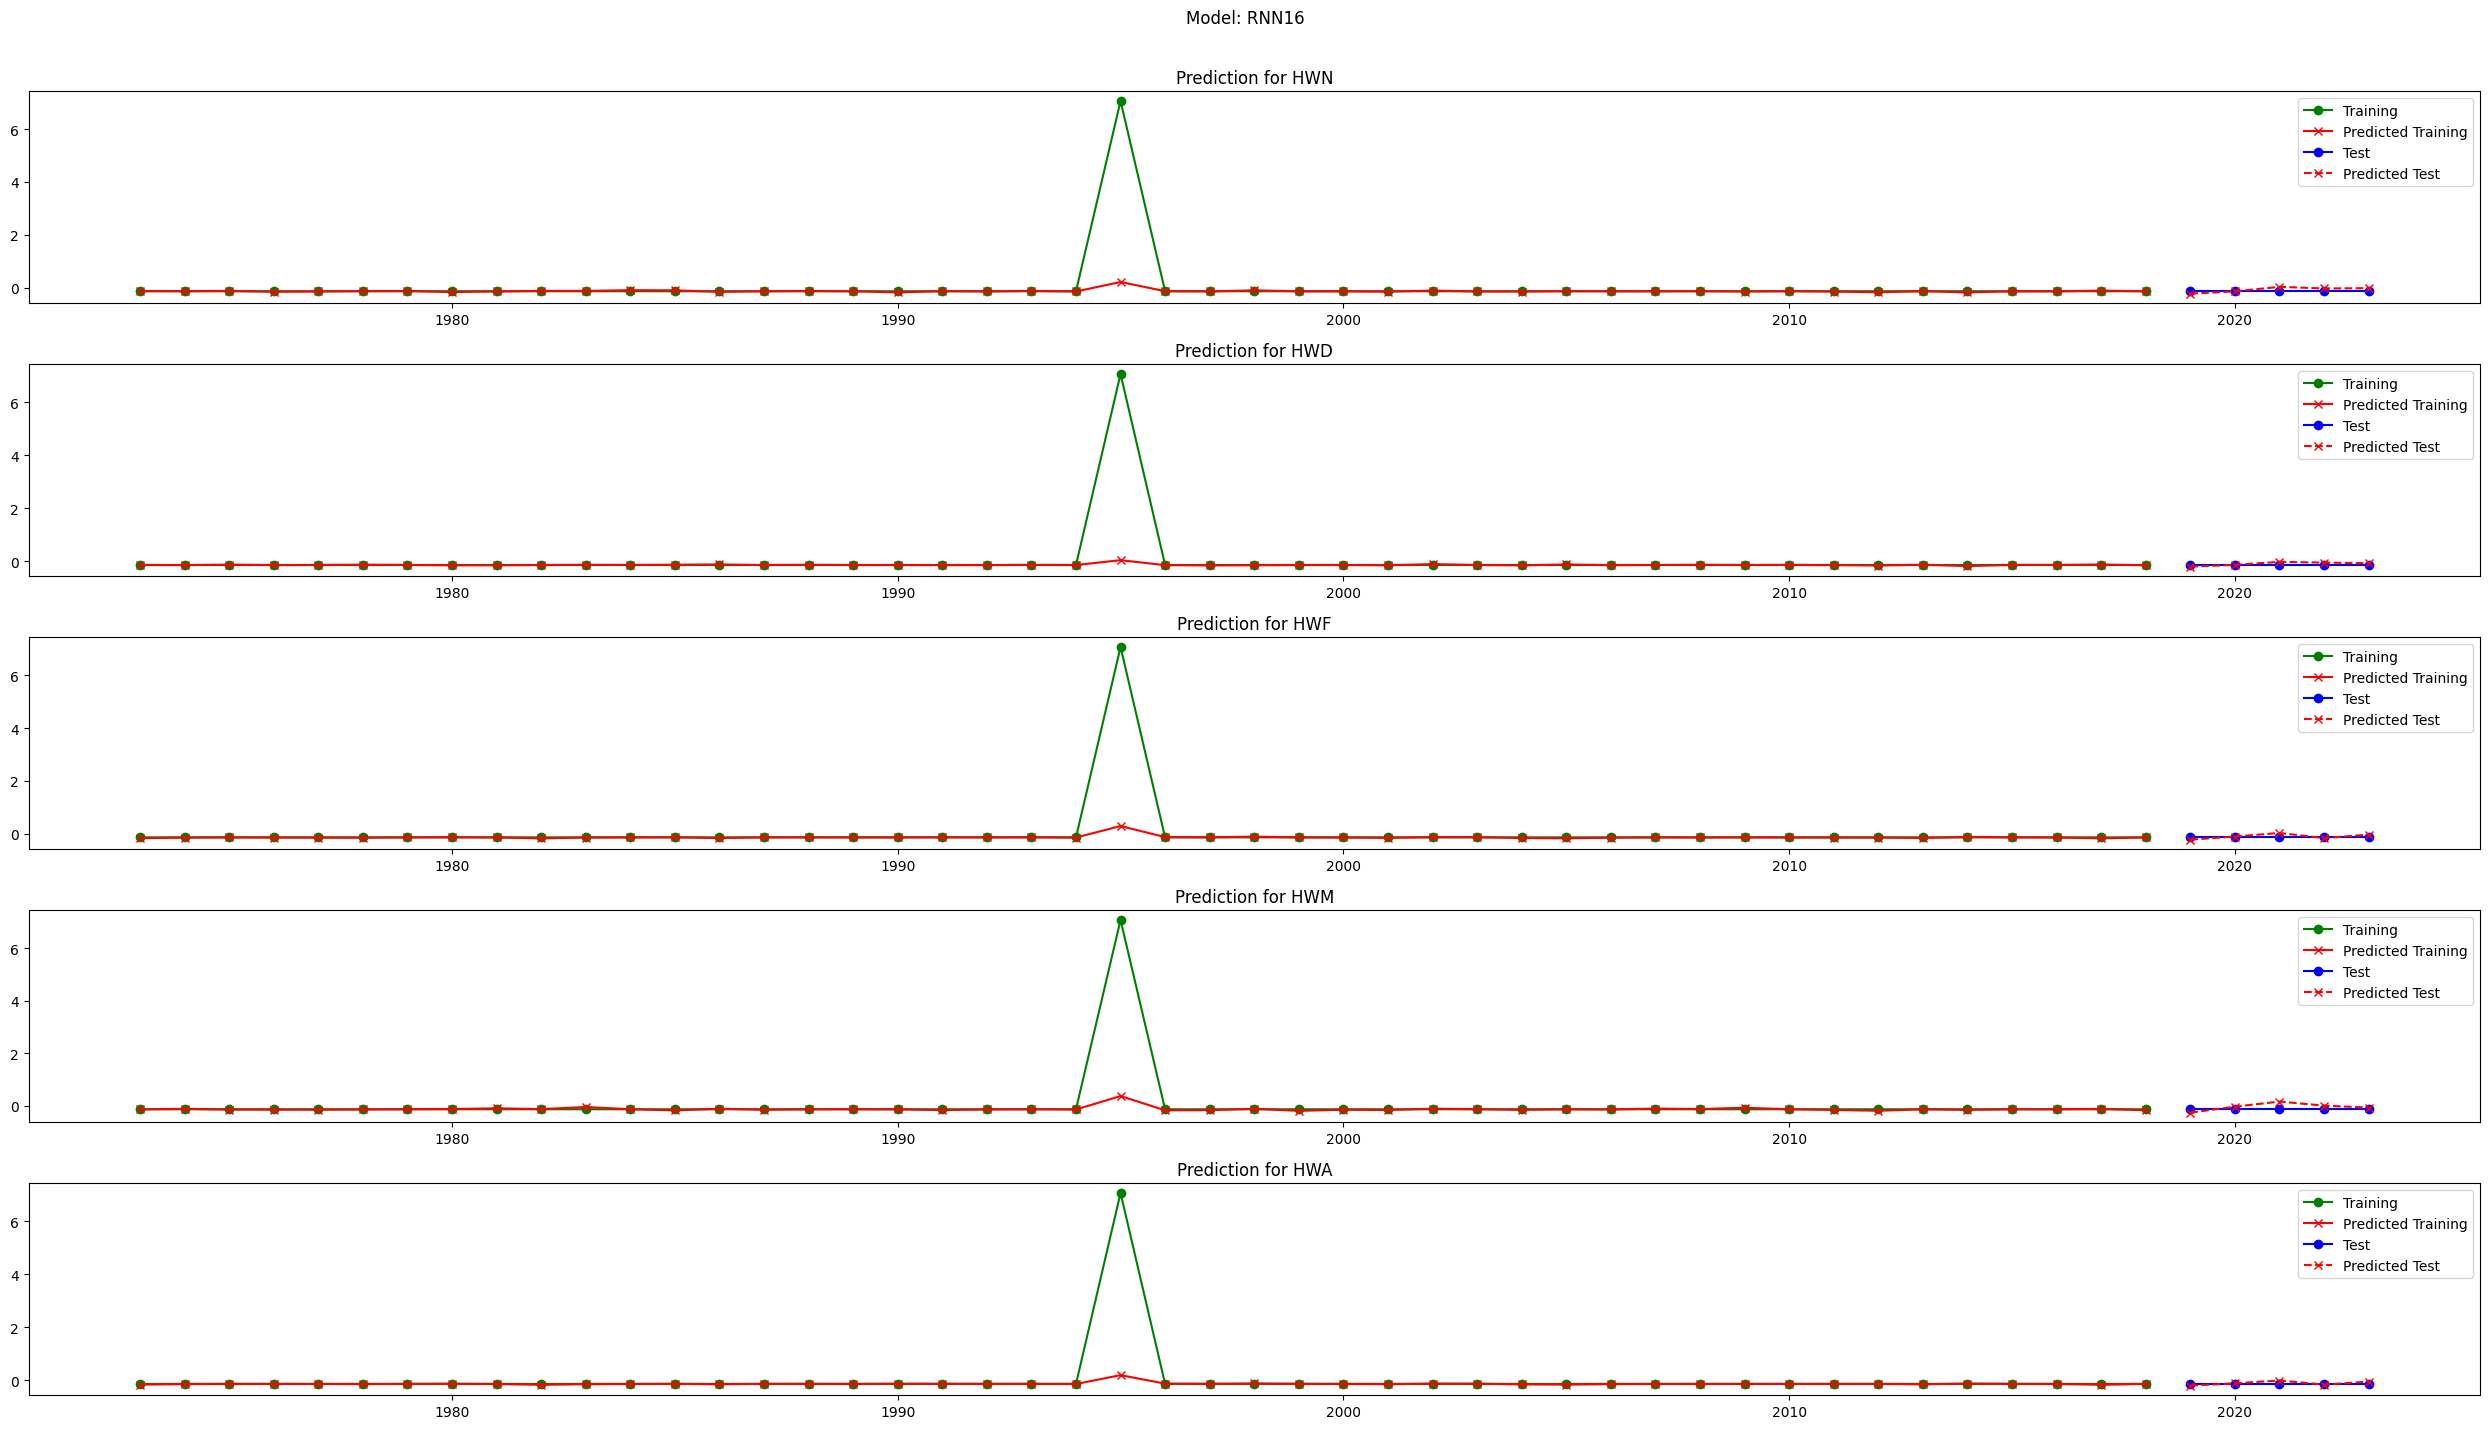

In [17]:
id = "e0ec7330"
season = 6
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])
pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model(metrics=[make_sera_metric(relevance)])
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

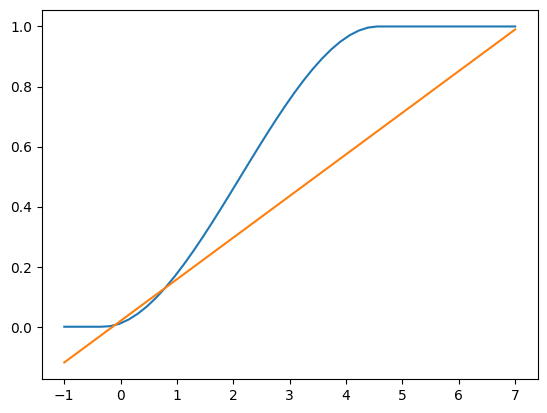

In [18]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, pred.training_relevance_fs["HWF"](x))

Epoch 1/200
6/6 [==============================] - 1s 40ms/step - loss: 0.4544 - sera_metric: 0.0042 - val_loss: 0.5660 - val_sera_metric: 0.0069
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 0.3879 - sera_metric: 0.0034 - val_loss: 0.5197 - val_sera_metric: 0.0059
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 0.3644 - sera_metric: 0.0031 - val_loss: 0.4747 - val_sera_metric: 0.0051
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.3382 - sera_metric: 0.0027 - val_loss: 0.4305 - val_sera_metric: 0.0043
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.3020 - sera_metric: 0.0023 - val_loss: 0.3936 - val_sera_metric: 0.0037
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 0.2781 - sera_metric: 0.0020 - val_loss: 0.3685 - val_sera_metric: 0.0033
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 0.2653 - sera_metric: 0.0019 - val_loss: 0.3495 - val_ser

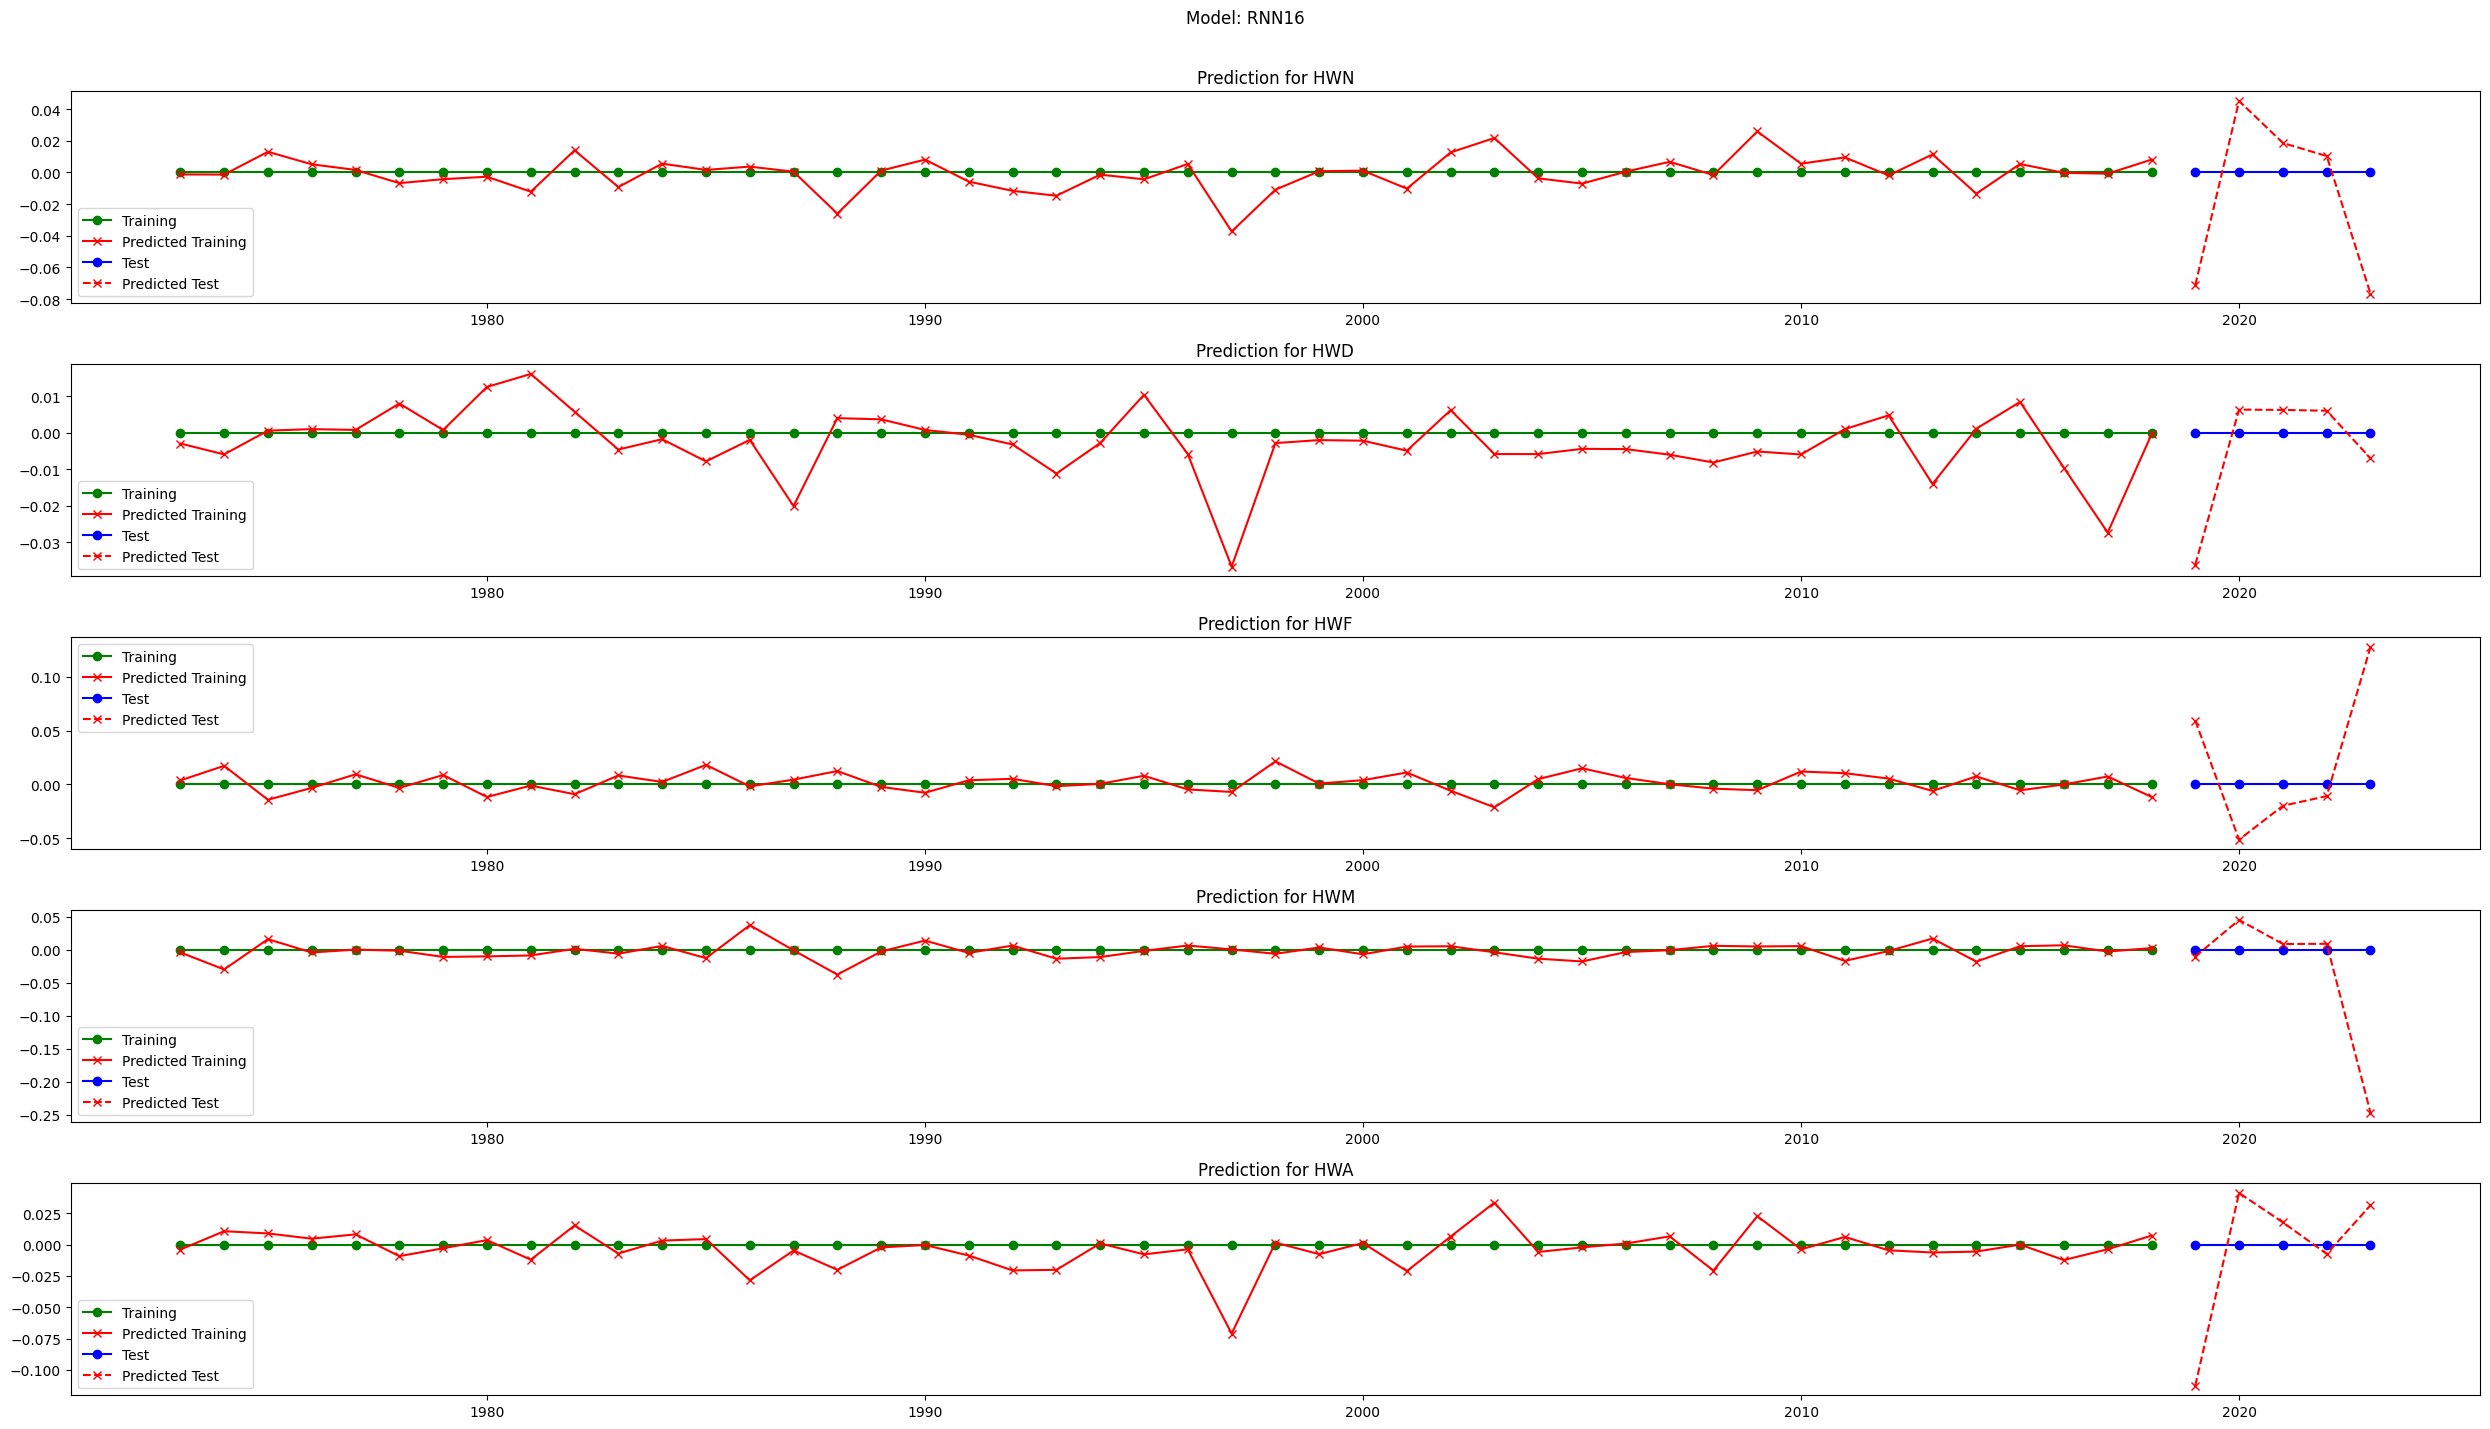

In [36]:
id = "c6b5cfea"
season = 12
region = 'california'
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])
pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model(metrics=[make_sera_metric(relevance)])
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)